In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from pathlib import Path
from src import Encoder, Decoder
import numpy as np
import matplotlib.pyplot as plt
import librosa
import src.data_signal as signal


In [ ]:
encoder = Encoder(modulation='bpsk')

encoder.encode(Path('test.txt'), Path('text.txt.wav'), sample_rate=16000)


In [ ]:
decoder = Decoder(modulation='bpsk')

decoder.decode_file(Path('text.txt.wav'))

In [ ]:
y, sample_rate = librosa.load(Path('test.png.wav'), sr=44100)

plt.plot(y)

In [80]:
fig, ax = plt.subplots()
# y, sample_rate = librosa.load(Path('test_audio.webm'))
y, sample_rate = librosa.load(Path('test_new_encode.png.wav'), sr=8192)
print("Sample rate: ", sample_rate)
S = librosa.feature.melspectrogram(y=y, sr=sample_rate, n_mels=256, fmax=8192)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                               y_axis='mel', sr=sample_rate,
                               fmax=8192, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

Sample rate:  8192


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

In [133]:
%matplotlib qt
sample_rate = 4 * 2048
y, _ = librosa.load(Path('test_new_encode.txt.wav'), sr=sample_rate)
y = y / np.max(np.abs(y))
end_noise = np.random.normal(0, 0.005, 4000)
# y = np.concatenate([y, end_noise])

y_nc, _ = librosa.load(Path('test_nc.txt.wav'), sr=sample_rate)
y_nc = np.concatenate([y_nc, end_noise])

carrier_signal_t = np.arange(0, y.shape[0])
carrier_signal = np.sin(2 * np.pi * carrier_signal_t / 16)

y_q = y * carrier_signal

fft_q = np.fft.fft(y_q)
freq = np.fft.fftfreq(len(y), 1 / 96000)
freq_mask = np.abs(freq) > 4000
fft_q[freq_mask] = 0

plt.subplot(3, 1, 1)
plt.plot(y)
plt.plot(y_q)

plt.subplot(3, 1, 2)
plt.plot(np.fft.ifft(fft_q))

plt.subplot(3, 1, 3)
plt.plot(y_nc)

plt.show()

In [136]:
def remove_carrier(signal: np.ndarray, sample_rate: int, f_c: int) -> np.ndarray:
    t = np.arange(0, len(signal) / sample_rate, 1 / sample_rate)
    carrier_signal = np.sin(2 * np.pi * f_c * t)
    signal = signal * carrier_signal

    plt.plot(signal)

    fft = np.fft.fft(signal)
    freq = np.fft.fftfreq(len(signal), 1 / sample_rate)
    freq_mask = np.abs(freq) > 512
    fft[freq_mask] = 0
    print(np.vstack([fft, freq]).T[:33])
    return np.fft.ifft(fft)

plt.figure()
plt.plot(y[:512])
y_no_carrier = remove_carrier(y[:512], sample_rate, sample_rate / 4)
plt.plot(y_no_carrier)

[[-6.10165298e-05+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [-4.71483576e+00+1.66533454e-16j  1.60000000e+01+0.00000000e+00j]
 [-4.71454286e+00+2.22044605e-16j  3.20000000e+01+0.00000000e+00j]
 [ 4.71473312e+00+3.33066907e-16j  4.80000000e+01+0.00000000e+00j]
 [-4.71456998e+00+1.38777878e-16j  6.40000000e+01+0.00000000e+00j]
 [-4.71389992e+00-3.60822483e-16j  8.00000000e+01+0.00000000e+00j]
 [ 4.71493526e+00+1.66533454e-16j  9.60000000e+01+0.00000000e+00j]
 [-4.71504237e+00+5.55111512e-17j  1.12000000e+02+0.00000000e+00j]
 [-4.71427514e+00-1.94289029e-16j  1.28000000e+02+0.00000000e+00j]
 [ 4.71479412e+00+1.66533454e-16j  1.44000000e+02+0.00000000e+00j]
 [-4.71499575e+00-2.63677968e-16j  1.60000000e+02+0.00000000e+00j]
 [ 4.71444510e+00+9.71445147e-17j  1.76000000e+02+0.00000000e+00j]
 [ 4.71485704e+00+1.94289029e-16j  1.92000000e+02+0.00000000e+00j]
 [ 4.71448530e+00-2.77555756e-17j  2.08000000e+02+0.00000000e+00j]
 [ 4.71475026e+00+1.24900090e-16j  2.24000000e+02+0.00000000e+

In [41]:
averaging_window_len = int(sample_rate * 0.005)

ranges, y_loudness = signal.extract_loud_signal_ranges(y, 0.006, averaging_window_len)

plt.figure()
plt.plot(y)
plt.plot(y_loudness)
for _r in ranges:
    if not _r.value:
        continue

    plt.axvline(_r.start, color='r', linestyle='--')
    plt.axvline(_r.end, color='r', linestyle='--')
plt.show()

In [49]:
averaging_window_len = int(sample_rate * 0.005)

ranges, y_loudness = signal.extract_loud_signal_ranges(y, 0.006, averaging_window_len)

valid_ranges = [r for r in ranges if r.value]

n_subcarriers = 64
cyclic_prefix_length = 16

# fig, axs = plt.subplots(nrows=len(valid_ranges), figsize=(15, 5))
plt.figure(figsize=(15, 5))

def remove_carrier(signal: np.ndarray, sample_rate: int, f_c: int) -> np.ndarray:
    t = np.arange(0, len(signal) / sample_rate, 1 / sample_rate)
    carrier_signal = np.sin(2 * np.pi * f_c * t)
    signal = signal * carrier_signal

    fft = np.fft.fft(signal)
    freq = np.fft.fftfreq(len(signal), 1 / sample_rate)
    freq_mask = np.abs(freq) > 260
    fft[freq_mask] = 0
    return np.fft.ifft(fft)


for i, r in enumerate(valid_ranges):
    print(r.start, r.end, r.value)

    if not r.value:
        continue

    prefix_to_subcarrier_ratio = cyclic_prefix_length / n_subcarriers
    prefix_len = int(prefix_to_subcarrier_ratio * r.length)

    print(prefix_len)

    raw_signal = y[r.start:r.end]
    plt.figure()
    plt.plot(raw_signal)
    signal_no_carrier = remove_carrier(raw_signal, sample_rate, sample_rate / 4)

    # axs[i].set_title(f"OFDM Frame {i} ({r.start} - {r.end})")
    plt.plot(signal_no_carrier)

    # cp = y[r.start:][:prefix_len]
    # ofdm_frame = y[r.start + prefix_len:r.end]
    #
    # ofdm_match_scores = np.convolve(ofdm_frame, cp, mode='valid')
    #
    # axs[i].set_title(f"OFDM Frame {i} ({r.start} - {r.end})")
    # axs[i].plot(ofdm_match_scores)
    # axs[i].plot()

plt.tight_layout()
plt.show()


0 659 True
164


KeyboardInterrupt: 

Current sample rate:  2000.0
Current duration:  0.020833333333333332


62.5

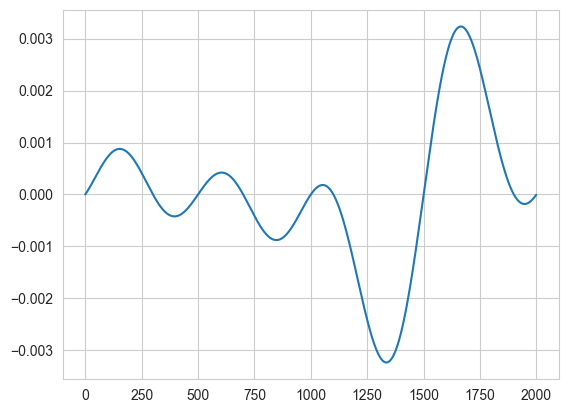

In [56]:
# synthesise signal of length 1 second and rescale as needed!
%matplotlib inline
n_carriers = 4
# supersamling  = 16
target_ofdm_f = 1000
# sig_length = 4 * 2 * supersamling
sig_length = 2 * target_ofdm_f
coeffs = np.zeros(sig_length, dtype=np.complex128)
coeffs[1:n_carriers + 1] = [1, 1j, -1, -1j]
coeffs[-n_carriers:] = np.conj(np.flip(coeffs[1:n_carriers + 1]))
ofdm_frame = np.fft.ifft(coeffs)
f_ofdm = len(ofdm_frame) / 2 / supersamling

curr_sr = sig_length / 1


target_sr = 96000
curr_duration_dicr = curr_sr / target_sr
print('Current sample rate: ', curr_sr)
print('Current duration: ', curr_duration_dicr)





plt.plot(ofdm_frame)
f_ofdm

In [66]:
t = np.linspace(0, 1, 512)

sin_1t = np.sin(2 * np.pi * 1 * t)
sin_20t = np.sin(2 * np.pi * 20 * t)

signal = sin_1t * sin_20t

fft = np.real(np.fft.fft(signal))
freq = np.fft.fftfreq(len(signal), d=1/512)

fft_demod = np.real(np.fft.fft(signal * np.sin(2 * np.pi * 20 * t)))

In [96]:
%matplotlib qt
# sr = 96000
sr = 10240
# sr = 2560
ofdm_freq = 1024
coeffs = np.zeros(sr, dtype=np.complex128)
num_carriers = 8
for i in range(num_carriers):
    coeffs[(ofdm_freq // num_carriers * (i + 1))] = 1

min_symbol_length_s = 1 / (ofdm_freq / num_carriers)
print('Symbol length: ', min_symbol_length_s)

coeffs[-sr // 2:] = np.conj(np.flip(coeffs[1:sr // 2 + 1]))
signal = np.fft.ifft(coeffs)
plt.plot(np.real(signal))

Symbol length:  0.0078125


In [97]:
min_symbol_length_s * sr

fft = np.fft.fft(signal[:80])
fft_r = np.real(fft)
fft_freq = np.fft.fftfreq(len(fft), d=1/sr)